In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import uniform, randint

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

#  Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold # Stratified K-fold cross validation


# Evaluation 
from sklearn.metrics import accuracy_score, confusion_matrix # accuracy and confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report # precision, recall, and f1
from sklearn.metrics import roc_auc_score # roc and auc

# Pipeline and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Evaluation metric
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix # accuracy and confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report # precision, recall, and f1
from sklearn.metrics import plot_roc_curve, roc_auc_score # roc and auc

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.tree import export_text
from sklearn.tree import plot_tree

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")
import sklearn
print(sklearn.__version__)

1.0.1


In [2]:
loan = pd.read_csv("used_df.csv")

loan = loan.drop(columns = ['dti_joint', 'verification_status_joint', 'Unnamed: 0', 'verification_status', 'id', 'zip_code',
                           'mths_since_last_major_derog', 'initial_list_status'])

# Get the shape
print("Data shape (rows, cols):")
print(loan.shape)

# Get the column types
print("\nFeature types:")
print(loan.dtypes)

# Get the missing values
print("\nMissing info:")
print(loan.isna().sum())

Data shape (rows, cols):
(887379, 24)

Feature types:
loan_amnt                     float64
term                           object
int_rate                      float64
installment                   float64
emp_length                     object
home_ownership                 object
loan_status                    object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
collections_12_mths_ex_med    float64
application_type               object
acc_now_delinq                float64
total_rev_hi_lim              float64
dtype: object

Missing info:
loan_

In [3]:
loan["term"] = loan.term.apply(lambda x: int(x.strip()[:2]))


loan["delinq_2yrs"] = loan["delinq_2yrs"].fillna(loan.delinq_2yrs.mode().loc[0])
loan["inq_last_6mths"] = loan["inq_last_6mths"].fillna(loan.inq_last_6mths.mode().loc[0])
loan["open_acc"] = loan["open_acc"].fillna(loan.open_acc.mode().loc[0])
loan["pub_rec"] = loan["pub_rec"].fillna(loan.pub_rec.mode().loc[0])
loan["total_acc"] = loan["total_acc"].fillna(loan.total_acc.mode().loc[0])
loan["collections_12_mths_ex_med"] = loan["collections_12_mths_ex_med"].fillna(loan.collections_12_mths_ex_med.mode().loc[0])
loan["acc_now_delinq"] = loan["acc_now_delinq"].fillna(loan.acc_now_delinq.mode().loc[0])
loan["total_rev_hi_lim"] = loan["total_rev_hi_lim"].fillna(loan.total_rev_hi_lim.median())
loan["revol_util"] = loan["revol_util"].fillna(loan.revol_util.median())
loan["emp_length"] = loan["emp_length"].fillna(loan.emp_length.mode().loc[0])

loan = loan.replace(["Charged Off", "Does not meet the credit policy. Status:Charged Off"], "Default")
loan = loan.replace(["Current", "Fully Paid", "Late (31-120 days)", "Issued", "In Grace Period", "Late (16-30 days)",
                    "Does not meet the credit policy. Status:Fully Paid"], "Not Default")

emp_dummy = pd.get_dummies(loan.emp_length, prefix='emp_len')
loan = pd.concat([loan,emp_dummy], axis = 1)
home_dummy = pd.get_dummies(loan.home_ownership, prefix='home_own')
loan = pd.concat([loan,home_dummy], axis = 1)
app_type_dummy = pd.get_dummies(loan.application_type, prefix='app_type')
loan = pd.concat([loan,app_type_dummy], axis = 1)

# if you have excuted this cell more than one time, duplicated dummy variables will be created
# We use the following method to remove duplicated columns
loan = loan.loc[:, ~loan.columns.duplicated()] 

loan = loan.drop(columns = ['emp_length', 'home_ownership', 'application_type'])
loan = loan.drop(columns = ["recoveries", "collection_recovery_fee"])
loan = loan.drop(columns = ["out_prncp"])

#print("\nMissing info:")
#print(loan.isna().sum())

#print("\nFeature types:")
#print(loan.dtypes)

#loan.head()

loan_sample = loan.sample(10000)

In [4]:
print(loan.loan_status.value_counts())

print(loan_sample.loan_status.value_counts())

Not Default    840151
Default         47228
Name: loan_status, dtype: int64
Not Default    9467
Default         533
Name: loan_status, dtype: int64


In [5]:
# Define class labels
target_name = "loan_status"

# Create a dataframe for input attributes
X = loan_sample.drop(target_name, axis = 1)

# Create a dataframe for class labels
y = loan_sample[target_name]

# Obtain attribute(feature) names (used for tree visualization)
fnames = list(X.columns)
print(fnames)

# Obtain the index (row identifier)
findex = X.index

# Obtain class label names
cnames = np.sort(y.unique())
# notice that survived outcome is numbers. we need to convert to str for future use.
cnames = [str(x) for x in cnames] 

print(cnames)

['loan_amnt', 'term', 'int_rate', 'installment', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'total_rev_hi_lim', 'emp_len_1 year', 'emp_len_10+ years', 'emp_len_2 years', 'emp_len_3 years', 'emp_len_4 years', 'emp_len_5 years', 'emp_len_6 years', 'emp_len_7 years', 'emp_len_8 years', 'emp_len_9 years', 'emp_len_< 1 year', 'home_own_ANY', 'home_own_MORTGAGE', 'home_own_NONE', 'home_own_OTHER', 'home_own_OWN', 'home_own_RENT', 'app_type_INDIVIDUAL', 'app_type_JOINT']
['Default', 'Not Default']


In [6]:
scaler = MinMaxScaler()
X_array = scaler.fit_transform(X)
X = pd.DataFrame(X_array, columns = fnames, index = findex)
X.describe()

,loan_amnt,term,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,...,emp_len_9 years,emp_len_< 1 year,home_own_ANY,home_own_MORTGAGE,home_own_NONE,home_own_OTHER,home_own_OWN,home_own_RENT,app_type_INDIVIDUAL,app_type_JOINT
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.403155,0.296000,0.331846,0.296941,0.277747,0.017489,0.034890,0.118994,0.018950,0.482640,...,0.033700,0.085100,0.0,0.503100,0.0,0.0001,0.095400,0.401400,0.998800,0.001200
std,0.249376,0.456514,0.183327,0.176850,0.128241,0.046320,0.050793,0.059978,0.054131,0.210618,...,0.180465,0.279044,0.0,0.500015,0.0,0.0100,0.293781,0.490206,0.034622,0.034622
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000
25%,0.205882,0.000000,0.197296,0.171634,0.180951,0.000000,0.000000,0.078652,0.000000,0.327434,...,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,1.000000,0.000000
50%,0.352941,0.000000,0.324039,0.256572,0.270657,0.000000,0.000000,0.112360,0.000000,0.491150,...,0.000000,0.000000,0.0,1.000000,0.0,0.0000,0.000000,0.000000,1.000000,0.000000
75%,0.558824,1.000000,0.442755,0.394747,0.367326,0.000000,0.050000,0.146067,0.000000,0.645133,...,0.000000,0.000000,0.0,1.000000,0.0,0.0000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,0.0,1.0000,1.000000,1.000000,1.000000,1.000000


In [7]:
chi_score, chi_p = chi2(X, y)
chi_df = pd.DataFrame(list(zip(fnames, chi_score, chi_p)), columns = ['Feature', 'Chi2' , 'chi_p']).sort_values(
    by = 'Chi2', ascending = False).reset_index(drop = True)
print(chi_df)

print(loan.describe())

                       Feature       Chi2         chi_p
0           total_rec_late_fee  93.035128  5.137436e-22
1                     int_rate  19.467415  1.023306e-05
2              total_rec_prncp  12.153030  4.900818e-04
3                home_own_RENT   9.151790  2.484749e-03
4               inq_last_6mths   6.691284  9.688539e-03
5            home_own_MORTGAGE   4.072210  4.359420e-02
6                total_rec_int   3.928428  4.747631e-02
7              emp_len_5 years   3.792081  5.149559e-02
8              emp_len_6 years   3.702451  5.433261e-02
9                         term   3.613615  5.730841e-02
10           emp_len_10+ years   3.348843  6.725225e-02
11             emp_len_4 years   3.297922  6.936759e-02
12             emp_len_2 years   2.613534  1.059554e-01
13                home_own_OWN   2.444710  1.179217e-01
14            emp_len_< 1 year   2.164901  1.411937e-01
15             emp_len_9 years   1.492552  2.218209e-01
16                     pub_rec   1.209201  2.714

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.3, #20% for testing and 80% for training
                                                  random_state = 1, 
                                                  stratify = y) # Make sure class label distributions are comparable

over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")


Training target statistics: Counter({'Not Default': 6627, 'Default': 6627})
Testing target statistics: Counter({'Not Default': 2840, 'Default': 160})


In [9]:
scv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 1) # Divide data into 4 equal-sized dispoint subsets.
                                                                   # I use the same random_state and shuffle = True
                                                                   # to make sure we get the exactly the same split

In [10]:
dt = DecisionTreeClassifier(random_state = 1, criterion = 'entropy')

param_grid = {'max_depth': range(3, 10), # choose a integer between 5 and 10
              'min_impurity_decrease': np.linspace(0.001, 0.005, 3),
             'min_samples_split': range(2, 5)} # choose 5 evenly spaced number
                                                                      # between 0.001 to 0.003

clf_grid = GridSearchCV(dt, # Decision tree with default setting
                        param_grid, # Candidate parameters
                        cv = scv, # 4-fold cross validation defined above
                        verbose = 3, # show validation progress
                        scoring = 'accuracy', # Use accuracy to select the best model parameters
                        return_train_score = True) # Show training scores (e.g. accuracy)
clf_grid.fit(X_res, y_res) # Conduct cross validation on the training data

Fitting 4 folds for each of 63 candidates, totalling 252 fits
[CV 1/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=2;, score=(train=0.675, test=0.670) total time=   0.0s
[CV 2/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=2;, score=(train=0.682, test=0.685) total time=   0.1s
[CV 3/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=2;, score=(train=0.683, test=0.685) total time=   0.0s
[CV 4/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=2;, score=(train=0.690, test=0.669) total time=   0.0s
[CV 1/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=3;, score=(train=0.675, test=0.670) total time=   0.0s
[CV 2/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=3;, score=(train=0.682, test=0.685) total time=   0.0s
[CV 3/4] END max_depth=3, min_impurity_decrease=0.001, min_samples_split=3;, score=(train=0.683, test=0.685) total time=   0.0s
[CV 4/4] END max_depth=3, min_impurity_dec

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=1),
             param_grid={'max_depth': range(3, 10),
                         'min_impurity_decrease': array([0.001, 0.003, 0.005]),
                         'min_samples_split': range(2, 5)},
             return_train_score=True, scoring='accuracy', verbose=3)

In [11]:
# Print the tuned parameters and score
print(f"Tuned Decision Tree Parameters: {clf_grid.best_params_}")
print(f"Best score is {clf_grid.best_score_:.2%}")

y_pred_grid = clf_grid.predict(X_test)
print(f"The test data performance for the best model is {accuracy_score(y_test, y_pred_grid):.2%}")
print(classification_report(y_test, y_pred_grid, digits = 4))


Tuned Decision Tree Parameters: {'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_split': 2}
Best score is 81.88%
The test data performance for the best model is 78.50%
              precision    recall  f1-score   support

     Default     0.1386    0.5813    0.2238       160
 Not Default     0.9712    0.7965    0.8752      2840

    accuracy                         0.7850      3000
   macro avg     0.5549    0.6889    0.5495      3000
weighted avg     0.9268    0.7850    0.8405      3000



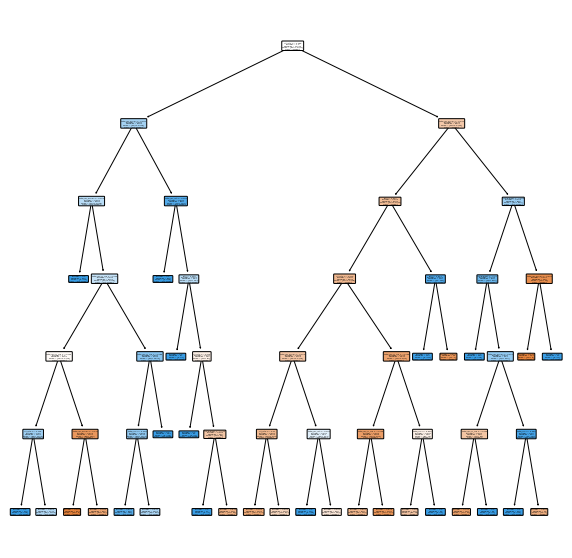

In [12]:
dt_best = DecisionTreeClassifier(random_state = 1, criterion = 'entropy', max_depth = 6, min_impurity_decrease = .001)
dt_best.fit(X_res, y_res)

# Define a function to print decision tree rules and save it in a text file
def viz_tree_fig(dt, fnames, cnames, figname):
    fig, ax = plt.subplots(figsize=(10, 10))  # whatever size you want
    plot_tree(dt, 
              feature_names = fnames, 
              class_names = cnames, 
              rounded = True, 
              filled = True,
              ax = ax) 
    fig.savefig(figname)
    
viz_tree_fig(dt_best, fnames, cnames, "tree_dep-3_entropy.pdf")

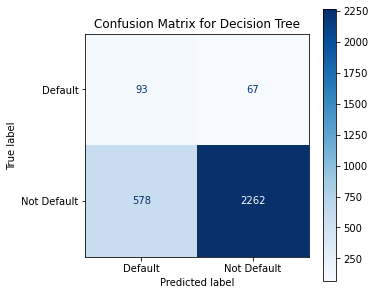

In [13]:
fig, ax = plt.subplots(figsize = (5,5))
plot_confusion_matrix(clf_grid, X_test, y_test,
                             cmap=plt.cm.Blues,
                             display_labels=cnames,
                             values_format = "d", # integer
                             ax = ax) # adjust the size
ax.set_title("Confusion Matrix for Decision Tree")
fig.savefig("ConfusionMatrix_DecisionTree.pdf")

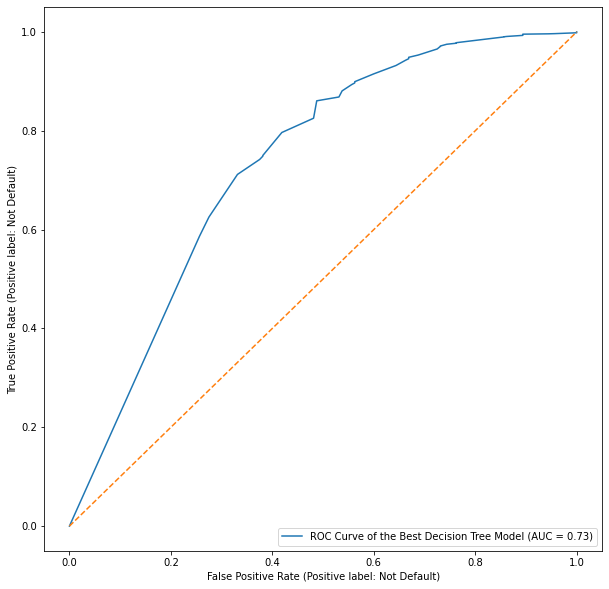

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
plot_roc_curve(clf_grid, X_test, y_test, name = "ROC Curve of the Best Decision Tree Model", ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--')
fig.savefig("ROC_Grid_Decision.jpeg")

In [15]:
rf_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf_clf', RandomForestClassifier(random_state = 1, max_features = 'auto'))])

parameters = {'rf_clf__max_depth': range(10,12)}

grid_clf = GridSearchCV(rf_clf, 
                        parameters, 
                        cv = 3, 
                        verbose = 3,
                        scoring = 'roc_auc', 
                        return_train_score = True)
grid_clf.fit(X_res, y_res) 

print(grid_clf.best_params_)
print(f'CV score: {grid_clf.best_score_}')

# Test
y_test_grid = grid_clf.predict(X_test)
acc_dt_grid = accuracy_score(y_test, y_test_grid)
print(f"The test data performance for the best random forest through grid search is: {acc_dt_grid:.2%}")
print(classification_report(y_test, y_test_grid, digits = 4))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END rf_clf__max_depth=10;, score=(train=0.989, test=0.982) total time=   0.9s
[CV 2/3] END rf_clf__max_depth=10;, score=(train=0.993, test=0.989) total time=   0.9s
[CV 3/3] END rf_clf__max_depth=10;, score=(train=0.992, test=0.986) total time=   0.9s
[CV 1/3] END rf_clf__max_depth=11;, score=(train=0.995, test=0.991) total time=   0.9s
[CV 2/3] END rf_clf__max_depth=11;, score=(train=0.998, test=0.996) total time=   1.0s
[CV 3/3] END rf_clf__max_depth=11;, score=(train=0.998, test=0.995) total time=   0.9s
{'rf_clf__max_depth': 11}
CV score: 0.9939803442069266
The test data performance for the best random forest through grid search is: 88.00%
              precision    recall  f1-score   support

     Default     0.1795    0.3500    0.2373       160
 Not Default     0.9613    0.9099    0.9349      2840

    accuracy                         0.8800      3000
   macro avg     0.5704    0.6299    0.5861      3000
weighted

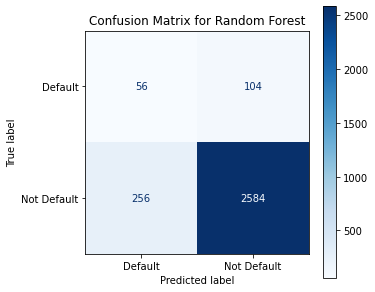

In [16]:
fig, ax = plt.subplots(figsize = (5,5))
plot_confusion_matrix(grid_clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             display_labels=cnames,
                             values_format = "d", # integer
                             ax = ax) # adjust the size
ax.set_title("Confusion Matrix for Random Forest")
fig.savefig("ConfusionMatrix_RandomForest.pdf")

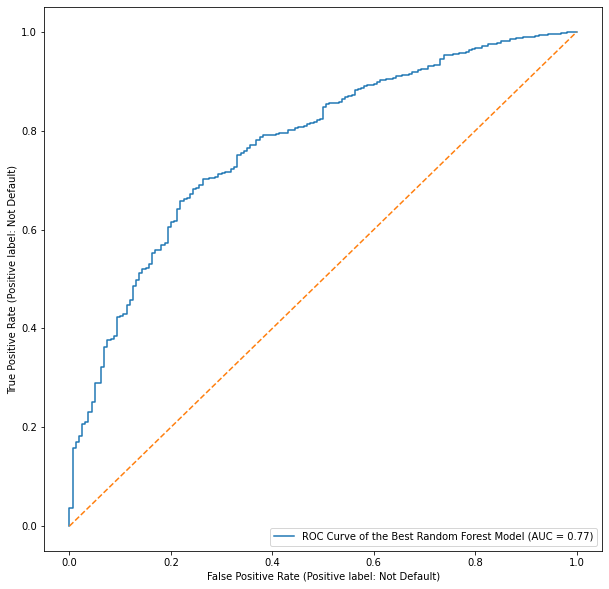

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
plot_roc_curve(grid_clf, X_test, y_test, name = "ROC Curve of the Best Random Forest Model", ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--')
fig.savefig("ROC_Grid_RandomForest.jpeg")

In [18]:
# Create Polynomial features

# Configure the model setting
log_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures()), 
        ('logistic_regression', LogisticRegression(random_state = 42))])


# Set tuning parameters, in this case grid search will run through 27 combinations defined by a dictionary
# Parameters of pipelines can be set using ‘__’ (double-underscore) separated parameter 
parameters = {'poly_features__degree':(1, 2),
              'logistic_regression__C': (1, 2, 3)}


grid_clf_log = GridSearchCV(log_clf, 
                        parameters, 
                        cv = 3, 
                        verbose = 3,
                        scoring = 'balanced_accuracy', 
                        return_train_score = True)
grid_clf_log.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END logistic_regression__C=1, poly_features__degree=1;, score=(train=0.507, test=0.528) total time=   0.1s
[CV 2/3] END logistic_regression__C=1, poly_features__degree=1;, score=(train=0.521, test=0.507) total time=   0.1s
[CV 3/3] END logistic_regression__C=1, poly_features__degree=1;, score=(train=0.523, test=0.512) total time=   0.1s
[CV 1/3] END logistic_regression__C=1, poly_features__degree=2;, score=(train=0.613, test=0.551) total time=   0.5s
[CV 2/3] END logistic_regression__C=1, poly_features__degree=2;, score=(train=0.641, test=0.532) total time=   0.4s
[CV 3/3] END logistic_regression__C=1, poly_features__degree=2;, score=(train=0.638, test=0.537) total time=   0.4s
[CV 1/3] END logistic_regression__C=2, poly_features__degree=1;, score=(train=0.507, test=0.532) total time=   0.1s
[CV 2/3] END logistic_regression__C=2, poly_features__degree=1;, score=(train=0.521, test=0.507) total time=   0.1s
[CV 3/3] END

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly_features', PolynomialFeatures()),
                                       ('logistic_regression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logistic_regression__C': (1, 2, 3),
                         'poly_features__degree': (1, 2)},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [19]:
print(grid_clf_log.best_params_)
print(f'CV score: {grid_clf_log.best_score_}')

# Test
y_test_grid = grid_clf_log.predict(X_test)
acc_dt_grid = accuracy_score(y_test, y_test_grid)
print(f"The test data performance for the best logistic regression through grid search is: {acc_dt_grid:.2%}")
print(classification_report(y_test, y_test_grid, digits = 4))

{'logistic_regression__C': 3, 'poly_features__degree': 2}
CV score: 0.5444912746973524
The test data performance for the best logistic regression through grid search is: 94.43%
              precision    recall  f1-score   support

     Default     0.4186    0.1125    0.1773       160
 Not Default     0.9520    0.9912    0.9712      2840

    accuracy                         0.9443      3000
   macro avg     0.6853    0.5518    0.5743      3000
weighted avg     0.9235    0.9443    0.9289      3000



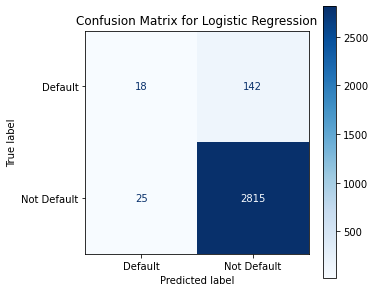

In [20]:
fig, ax = plt.subplots(figsize = (5,5))
plot_confusion_matrix(grid_clf_log, X_test, y_test,
                             cmap=plt.cm.Blues,
                             display_labels=cnames,
                             values_format = "d", # integer
                             ax = ax) # adjust the size
ax.set_title("Confusion Matrix for Logistic Regression")
fig.savefig("ConfusionMatrix_Log.pdf")

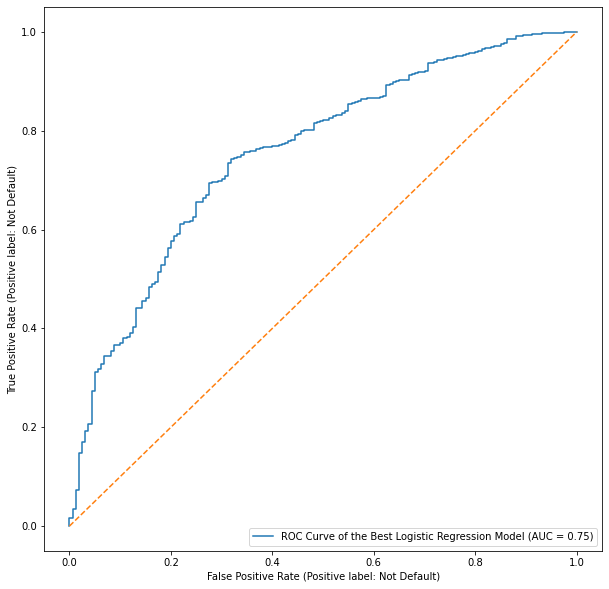

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
plot_roc_curve(grid_clf_log, X_test, y_test, name = "ROC Curve of the Best Logistic Regression Model", ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--')
fig.savefig("ROC_Grid_Log.jpeg")

In [22]:
# Create Polynomial features
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lg_poly = LogisticRegression(random_state = 42, C = 1)
lg_poly.fit(X_train_poly, y_train)

# Test
y_pred_lgpoly= lg_poly.predict(X_test_poly)
acc_log_poly = accuracy_score(y_test, y_pred_lgpoly)
print(f"The test data performance for the logistic regression is {acc_log_poly:.2%}")
print(classification_report(y_test, y_pred_lgpoly, digits = 4))

The test data performance for the logistic regression is 94.73%
              precision    recall  f1-score   support

     Default     0.6000    0.0375    0.0706       160
 Not Default     0.9485    0.9986    0.9729      2840

    accuracy                         0.9473      3000
   macro avg     0.7742    0.5180    0.5217      3000
weighted avg     0.9299    0.9473    0.9248      3000



# Cluster

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.simplefilter("ignore", UserWarning)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [31]:
loan.dtypes
cluster_df = loan[['loan_amnt', 'term', 'int_rate', 'installment', 'dti','delinq_2yrs','open_acc','pub_rec','revol_util','total_acc','total_rec_prncp', \
                  'total_rec_int','total_rec_late_fee','collections_12_mths_ex_med','acc_now_delinq']]

In [30]:
cluster_df.dtypes

loan_amnt                     float64
term                            int64
int_rate                      float64
installment                   float64
loan_status                    object
dti                           float64
delinq_2yrs                   float64
open_acc                      float64
pub_rec                       float64
revol_util                    float64
total_acc                     float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
collections_12_mths_ex_med    float64
acc_now_delinq                float64
dtype: object

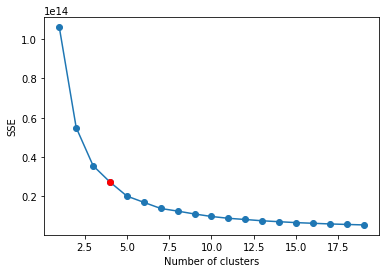

In [32]:
sse = [] # Sum of Squared Error of data points to centroid; The smaller the better.
for i in range(1, 20): # get the prefect number of clusters from 1 to 20
    customer_kmeans = KMeans(n_clusters = i, random_state = 42)
    customer_kmeans.fit(cluster_df)
    sse.append(customer_kmeans.inertia_)
    
plt.plot(range(1, 20), sse, marker = 'o')
plt.plot(4, sse[3], color = 'r', marker = 'o') # plot red mark on k = 4
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [33]:
customer_kmeans_4 = KMeans(n_clusters = 4, random_state = 42)
customer_kmeans_4.fit(cluster_df)
#customer_kmeans_4.labels_

KMeans(n_clusters=4, random_state=42)

In [35]:
cluster_df['cluster'] = customer_kmeans_4.labels_
print(cluster_df['cluster'].value_counts())
cluster_df.describe()

0    367195
2    310250
1    131680
3     78254
Name: cluster, dtype: int64


,loan_amnt,term,int_rate,installment,dti,delinq_2yrs,open_acc,pub_rec,revol_util,total_acc,total_rec_prncp,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,cluster
count,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000
mean,14755.264605,43.201090,13.246740,436.717127,18.157039,0.314432,11.548386,0.195301,55.068221,25.267919,5757.706424,1754.804327,0.396692,0.014377,0.004991,1.112199
std,8435.455601,10.998663,4.381867,244.186593,17.190626,0.862232,5.317246,0.582082,23.827612,11.840382,6625.441046,2095.356099,4.087825,0.134180,0.077624,1.050513
min,500.000000,36.000000,5.320000,15.670000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,36.000000,9.990000,260.705000,11.910000,0.000000,8.000000,0.000000,37.700000,17.000000,1200.570000,441.460000,0.000000,0.000000,0.000000,0.000000
50%,13000.000000,36.000000,12.990000,382.550000,17.650000,0.000000,11.000000,0.000000,56.000000,24.000000,3215.320000,1073.280000,0.000000,0.000000,0.000000,1.000000
75%,20000.000000,60.000000,16.200000,572.600000,23.950000,0.000000,14.000000,0.000000,73.600000,32.000000,8000.000000,2238.265000,0.000000,0.000000,0.000000,2.000000
max,35000.000000,60.000000,28.990000,1445.460000,9999.000000,39.000000,90.000000,86.000000,892.300000,169.000000,35000.030000,24205.620000,358.680000,20.000000,14.000000,3.000000


# make a persona for the top 2 clusters, group 0 and group 1

In [36]:
pd.set_option('display.max_rows', 100)
group = cluster_df.groupby('cluster').mean().T
group

cluster,0,1,2,3
loan_amnt,7279.022726,28159.154389,15457.638920,24496.655443
term,38.644088,50.974484,44.978050,44.458609
int_rate,12.701961,14.313258,13.222518,14.104403
installment,231.689673,779.463267,456.008761,745.544984
dti,17.890263,19.140259,18.407215,16.762491
delinq_2yrs,0.325710,0.332290,0.309457,0.251182
open_acc,10.571702,13.285260,11.794504,12.232870
pub_rec,0.251735,0.134614,0.181866,0.085874
revol_util,52.093370,59.594244,56.142855,57.150648
total_acc,22.748907,29.115310,25.770575,28.621042


# Cluster 0 (Careful Carla)
- smallest loan amount (on average $7,279 vs next largest group 15k)
- shortest term
- smallest interest rate
- smallest dti
- least open acc

- use the program to pick out risky Clavins that may have been missed by a human

# Cluster 1 (Risky Ricky)
- largest loan amount (28 k)
- longest term
- largest interest rate
- largest dti
- biggest risk
- Use program to maximize profits and give loans to Rickys that may be dismissed by humans 